# Excersies 5: Sparsity

There are different ways to deal with parameter sparsity in statistical methods. Since this class is all about big data, the method that we are going to use is the new-school frequentist way.

This method is based on penalizing the likelihood function in such a way that enforces sparsity on the parameter space. This is obtained by maximizing the **The penalized likelihood function** instead of the **vanilla likelihood function**. 

### Import libraries

In [174]:
import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
import copy
from numpy.linalg import norm
from sklearn.linear_model import LinearRegression


%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Penalized likelihood and soft thresholding

**(A)** Let's start by assuming that the data is coming from a Gaussian distribution with mean $\theta$ and variance 1. 

$$
\begin{align*}
& N(y|\theta, 1) = \frac{1}{\sqrt{2 \pi }}exp\left\{-\frac{1}{2} (y-\theta)^2 \right\}\\
& -\ell n N(y|\theta, 1) = +\frac{1}{2}\ell n(2 \pi) +\frac{1}{2} (y-\theta)^2 \\
& -\ell n N(y|\theta, 1)  \propto \frac{1}{2} (y-\theta)^2
\end{align*}
$$

Here, the constant term is not a function of $\theta$ so it can be dropped. So we proved that the quadratic term in the objective function is the negative log likelihood of a Gaussian distribution with mean $\theta$ and variance 1.

Next, we want to prove that 

$$
\begin{align*}
S_\lambda(y) &= \arg \min_{\theta} \; \frac{1}{2}(y - \theta)^2 + \lambda | \theta | \\
&= \mbox{sign}(y) \cdot (|y| - \lambda)_+ \,
\end{align*}
$$

Here, to prove this we use ordinary differential calculus. Let's calculate the derivative of penalized likelihood function with respect to $\theta$.

$$
\begin{align*}
& \ell = \frac{1}{2} (y-\theta)^2 + \lambda |\theta| \\
& \frac{\partial \ell}{\partial \theta} = -(y-\theta) + \lambda \frac{\partial}{\partial \theta} |\theta|  = -(y-\theta) + \lambda * sign(\theta)  \\
&= \begin{cases} 
      \theta - y + \lambda & \theta > 0 \\
      \theta - y - \lambda & \theta < 0 \\
       0 - y  + \lambda \partial |\theta| & \theta = 0 \\
   \end{cases}
\end{align*}
$$


If $\theta > 0$:

If $\theta < 0$:

If $\theta = 0$:


From all the above we can write $S_\lambda (y)$ in the following format:

$$
S_\lambda (y)= \mbox{sign}(y) \cdot (|y| - \lambda)_+
$$

To build some intuition, I am going to plot the objective function for various values of y and $\lambda$, and verify that $S_\lambda (y)$ is indeed obtains the minimum.

In [175]:
def soft_thresh(y, lambd):
    return np.sign(y) * np.maximum((np.abs(y) - lambd), np.zeros(1))

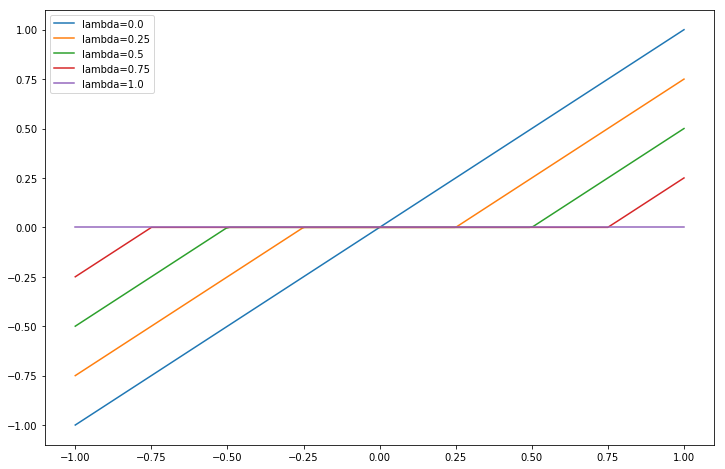

In [176]:
X = np.linspace(-1.0, 1.0, 501)
y = X**5
for i in np.linspace(0,1,5):
    plt.plot(y, soft_thresh(y, i), label="lambda=" + str(i))
plt.legend()
plt.show()

### toy example:

1 . First, let's generate a sparse vector with the given density with randomly distributed values. I also generate the corresponding $\sigma_i^2$ vector.

In [177]:
sparsity = .1
n = 50
theta = sp.rand(1,n, density=sparsity, format='csr')
print(theta)
variance = np.random.rand(n)**2

  (0, 23)	0.0208310993727
  (0, 34)	0.856946467322
  (0, 38)	0.161317768258
  (0, 39)	0.197072404338
  (0, 49)	0.291967934465


2 . simulate one data point $(z_i|\theta_i) \sim N(\theta_i, \sigma_i^2)$ for each $\theta_i$.

In [178]:
def generate_draws(theta, var):
    '''
    Inputs:
    theta: A sparse csr matrix of N means
    var: A dense N vector of variances
    
    Output:
    y: A dense N vector of random draws from gaussian distributions s.t. y_i is a 
        random draw from N(theta_i, var_i)    
    '''
    # Check and ensure sparse format
    if not sp.isspmatrix_csr(theta):
        theta = sp.csr_matrix(theta)
    index = theta.indices
    stdv = np.sqrt(var) 
    # Draw random samples from a normal (Gaussian) distribution with mean loc and standard deviation scale
    y = np.random.normal(scale=stdv)
    y[index] = np.random.normal(loc = theta.data, scale=stdv[index])
    return y
    
y = generate_draws(theta, variance)

3 . Plot $\hat \theta (y_i)$ vs $\theta_i$.

In [267]:
# Part 3: Plot \theta vs. threshhold(y) for various values of lambda
# sparsity = .3
# n = 50
# theta = sp.rand(1,n, density=sparsity, format='csr')
# variance = np.random.rand(n)**2
# y = generate_draws(theta, variance)
# lambdas = np.linspace(-1,1,10)
# #lambdas = (np.ones(5)*10)**(-np.arange(5))
# for i in lambdas:
#     threshhold = soft_thresh(y, i)
#     plt.plot(threshhold)
#     plt.scatter(theta.indices, theta.data, marker='*')
#     plt.title('Lambda = '+str(i))
#     plt.show()

4. Plot the mean squared error of the estimate as a function of $\lambda$.

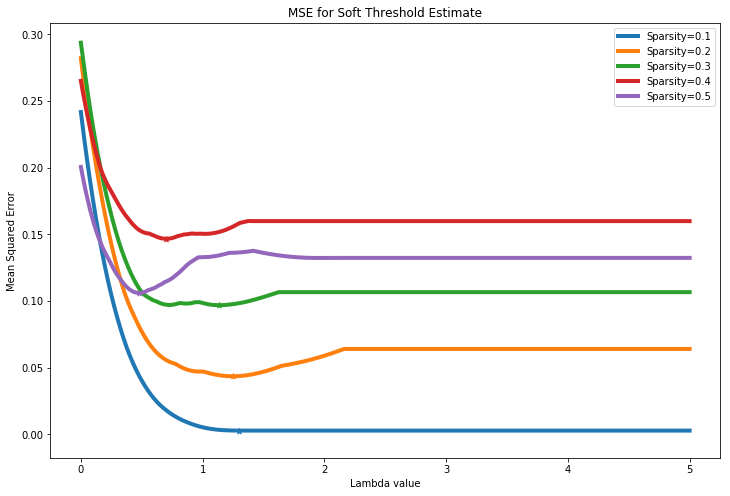

In [268]:
n = 50
lambdas = np.linspace(0, 5, 401)
MSE = np.zeros_like(lambdas)
variance = np.random.rand(n)**2

density = np.arange(.1, .6, .1)

for sparsity in density:
    theta = sp.rand(1,n, density=sparsity, format='csr')
    y = generate_draws(theta, variance)
    
    # Calculate the MSE for each lambda value
    for i in np.arange(lambdas.shape[0]):
        threshhold = soft_thresh(y, lambdas[i])
        MSE[i] = 1. / n * ((threshhold - theta.toarray().ravel())**2).sum()
    
    # Plot the minimum of the MSE
    argmin = np.argmin(MSE)
    plt.scatter(lambdas[argmin], MSE[argmin], marker='*')
    # Plot the MSE
    plt.plot(lambdas, MSE, label='Sparsity='+str(sparsity), linewidth = 4.0)

# Overall Plot
plt.xlabel('Lambda value')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.title('MSE for Soft Threshold Estimate')
plt.show()

## The Lasso

The lasso **(least absoulute shrinkage and selection operator)** involves estimating $\beta$ as the solution of the penalized least squares problem.

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\hat \beta = \argmin_\beta \frac{1}{2} || y - X\beta||_2^2 + \lambda ||\beta||_1
$$

where

$$
||\beta||_1 = \sum_{j=1}^{P}|\beta_j|
$$


Here, the penalty function both sparsify the estimate and also shrink the non-zero $\beta_i's$ toward zero. **The bigger $\lambda$, the more aggressive the shrinkage effect is.**

In [181]:
from sklearn.linear_model import lasso_path
from sklearn.linear_model import Lasso
from itertools import cycle

Let's first write a function to load the data:

In [194]:
# function to load the data in diabetes progression in 442 adults
def load_data():
    ## Read in the CSV data
    feature_matrix = np.loadtxt("../../data/diabetesX.csv",skiprows=1,delimiter=",")
    response = np.loadtxt("../../data/diabetesY.csv")
    
    return feature_matrix, response


In [195]:
# Unit-testing load_data:

X, Y = load_data()

assert(X.shape[0] == 442)
assert(X.shape[1] == 64)
assert(Y.shape[0] == 442)

# test if the mean of all columns are zero
assert(np.allclose(X.mean(axis=0), np.zeros(X.shape[1],)))

# test if the 2-norm of all columns are 1
assert(np.allclose(np.linalg.norm(X, axis = 0), np.ones(X.shape[1],)))

print('All tests passed!')

All tests passed!


### Normalize features

Let's write a function to normalize features. This is very important when using Lasso Regression. The reason is, to features with relatively bigger magnitudes much smaller weights would be assigned. This is problematic because "small" weights are dropped first as l1_penalty goes up.

To give equal considerations for all features: we divide each feature by its 2-norm so that the transformed feature has norm 1.

** Important Note: We always keep the original features norm data around as well to normalize the test data in the same way as we normalized the training data. Here, however, we don't have any test data...**

In [196]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis = 0)
    normalized_features = feature_matrix/norms
    return (normalized_features, norms)

In [197]:
# Unit testing normalize_features

features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print(features)
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print(norms)
# should print
# [5.  10.  15.]

[[ 0.6  0.6  0.6]
 [ 0.8  0.8  0.8]]
[  5.  10.  15.]


In [199]:
X, norms = normalize_features(X)

Fit the lasso model across a range of $\lambda$ values and plot the solution path $\hat \beta_\lambda$ as a function of $\lambda$. 

In [226]:
#  coeffs (n_features, n_alphas)
#  alphas  (n_alphas,)
print("Computing regularization path using the lasso...")
alphas, coeffs, _ = lasso_path(X,Y, n_alphas = 10, copy_X=True,)

Computing regularization path using the lasso...


(-0.48204308727893835,
 2.8179569127210615,
 -852.49829354970063,
 744.72737284684467)

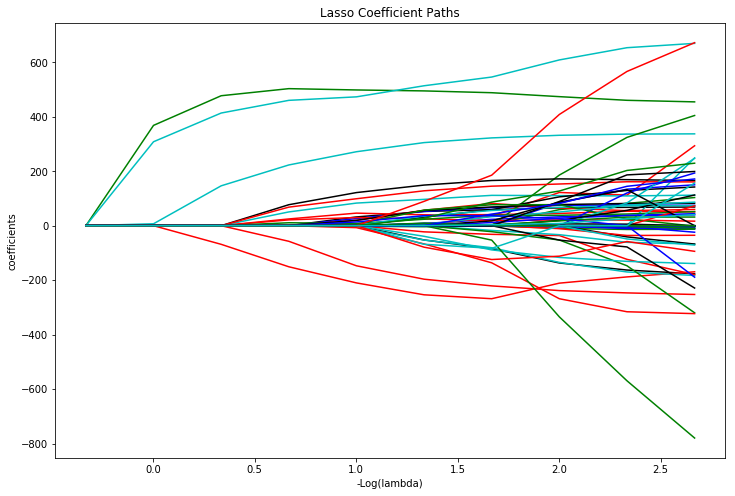

In [229]:
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas)

for coeff, color in zip(coeffs, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coeff, c=color)
    

plt.xlabel('-Log(lambda)')
plt.ylabel("coefficients")
plt.title("Lasso Coefficient Paths")
plt.axis('tight')


Next, let's calculate the in-sample mean_squared prediction error of the fit accross the solution path:

$$
MSE(\hat \beta_\lambda) = \frac{1}{n} \sum_{i=1}^{n} (y_i - x_i^T \hat \beta_\lambda^2) = \frac{1}{n} ||y - X\hat\beta_\lambda||_2^2
$$

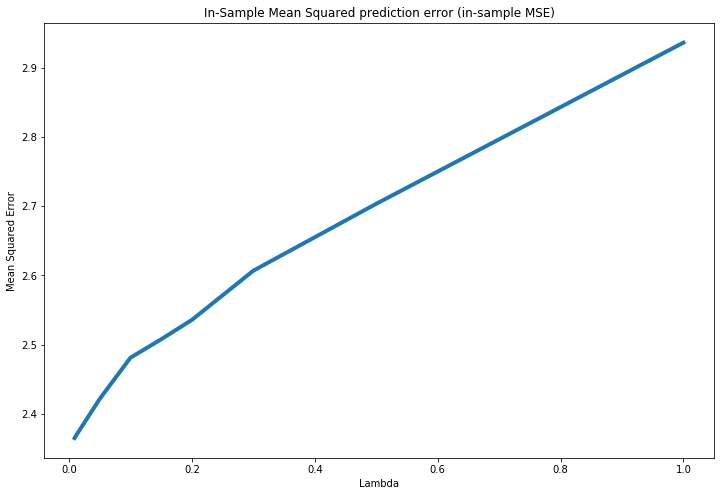

In [254]:
testLambdas = [9e-3, 1e-2, 5e-2, 0.1, 0.15, 0.2, 0.3, 0.5, 1]

mse = []

for a in testLambdas:
    lassofit = Lasso(alpha = a)
    lassofit.fit(X,Y)
    predicted = lassofit.predict(data)
    diff = predicted - response
    thismse = norm(diff) / np.size(diff)
    mse.append(thismse)

plt.plot(testLambdas, mse, linewidth=4.0)
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("In-Sample Mean Squared prediction error (in-sample MSE)")

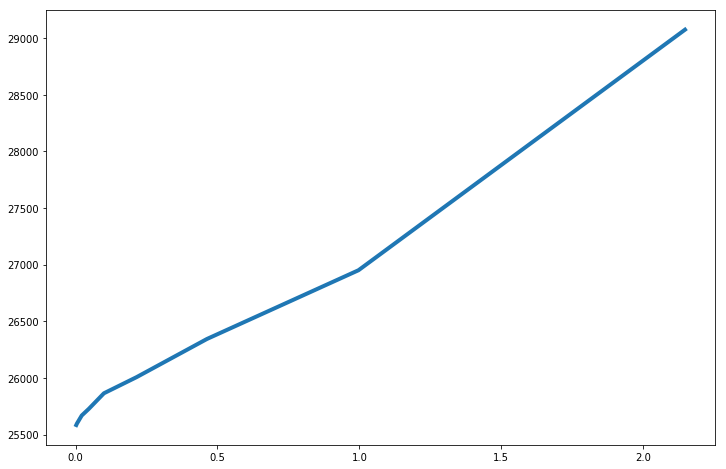

In [259]:
# Calculate the in-sample mean-squared prediction error
n = Y.shape[0]
XB = np.dot(X, coeffs)
Y_XB = Y - XB.T
MSE = 1. / n * (np.linalg.norm(Y_XB, axis=1))**2
plt.plot(alphas, MSE, linewidth = 4)
plt.show()

## Cross Validation:

In [260]:
def crossValLasso(X, y, lambdaval , fold = 10):
    """
    Cross validate a Lasso model
    X = data (as numpy array, predictors in columns)
    y = responses (as numpy array)
    lambdaval = float, value for lambda
    fold = an integer. 1/fold is the fold
               of the hold out data, e.g. fold=10
               is 10-fold cross validation
    return: a list of mean squared error resulting from
            each crossval trial, with len = fold
    """

    (N,P) = np.shape(X)

    ## Generate boundaries for the crossval. To be honest, this is probably
    # wrong but I can't bring myself to care enough
    boundaries = np.linspace(0, N, fold).tolist()
    boundaries = [ int(x) for x in boundaries ]

    errors = []

    for j in range(len(boundaries) - 1):
        toDelete = range(boundaries[j], boundaries[j+1])
        first = toDelete[0]
        last = toDelete[-1]
        trainX = np.delete(X, toDelete, axis=0)
        trainy = np.delete(y, toDelete, axis=0)
        testX = X[first:last,:]
        testy = y[first:last]

        lassofit = Lasso(alpha = lambdaval)
        lassofit.fit(trainX,trainy)

        predicted = lassofit.predict(testX)

        thisError = norm(testy - predicted)**2 / np.size(testy)

        errors.append(thisError)

    return errors

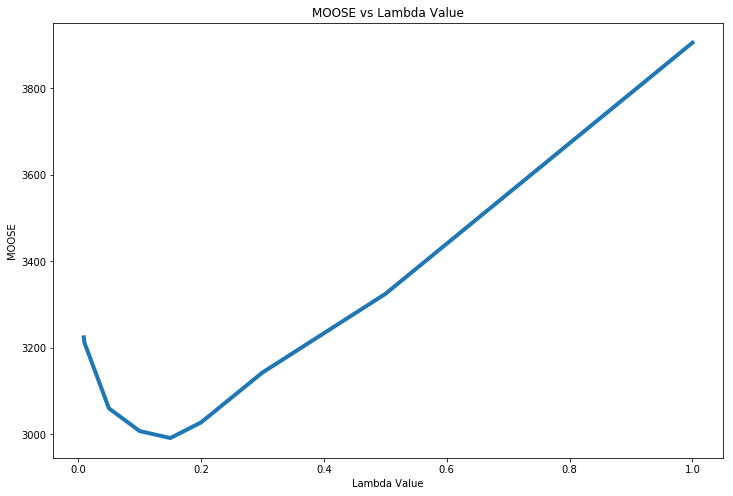

In [262]:
## Test Cross Validation

testLambdas = [9e-3, 1e-2, 5e-2, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
testLambdas.reverse()
moose = [] 

# 10-fold cross-validation
for l in testLambdas:
    errs = crossValLasso(X, Y, l)
    thismoose = sum(errs) / len(errs)
    moose.append(thismoose)
    
plt.plot(testLambdas, moose, linewidth=4.0)
plt.xlabel("Lambda Value")
plt.ylabel("MOOSE")
plt.title("MOOSE vs Lambda Value")

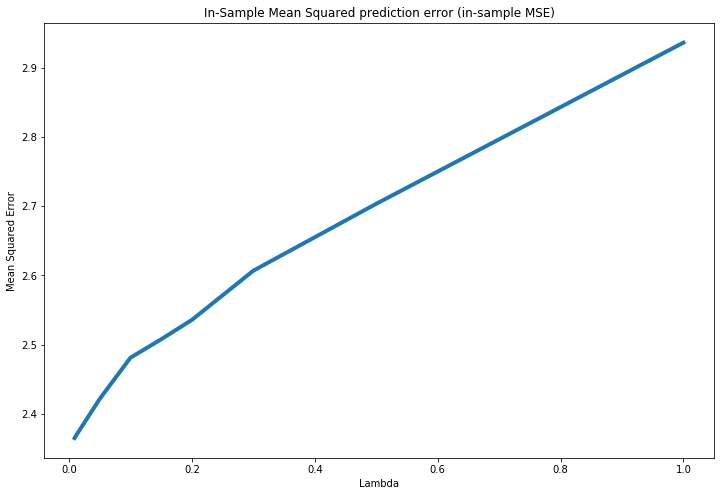

In [263]:
mse = []

for a in testLambdas:
    thislasso = Lasso(alpha = a)
    thislasso.fit(X,Y)
    predicted = thislasso.predict(data)
    diff = predicted - response
    thismse = norm(diff) / np.size(diff)
    mse.append(thismse)

plt.plot(testLambdas, mse, linewidth=4.0)
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("In-Sample Mean Squared prediction error (in-sample MSE)")

In [264]:
# Generate actual betas with lasso_path for calculating betas
lassoPathLambdas, coeffs, _ = lasso_path(X,Y, alphas = testLambdas)

betas = []

# Aggregate "coeffs" into individual vectors of betas
for j in range(len(coeffs[0])):
    betas.append(np.array([ x[j] for x in coeffs ]))

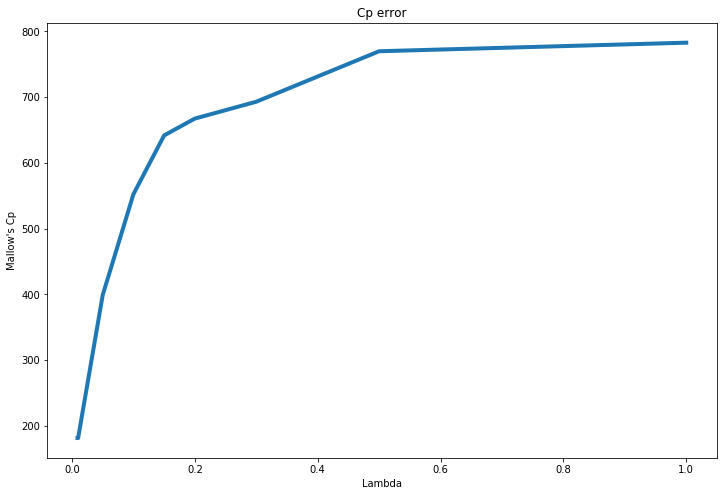

In [265]:
(N,P) = np.shape(X)

# Calculate variance
ols = LinearRegression()
ols.fit(data,response)
olspred = ols.predict(data)
sigmasquare = 1 / ( N - P ) * np.sum((response - olspred)**2)

Cp = copy.copy(mse)
# Modify in-sample MSE with Mallows terms
for j in range(len(Cp)):
    s = len(betas[j]) - np.count_nonzero(betas[j])
    Cp[j] += 2 * s / N * sigmasquare
    
plt.plot(testLambdas, Cp, linewidth=4.0)
plt.xlabel("Lambda")
plt.ylabel("Mallow's Cp")
plt.title("Cp error")

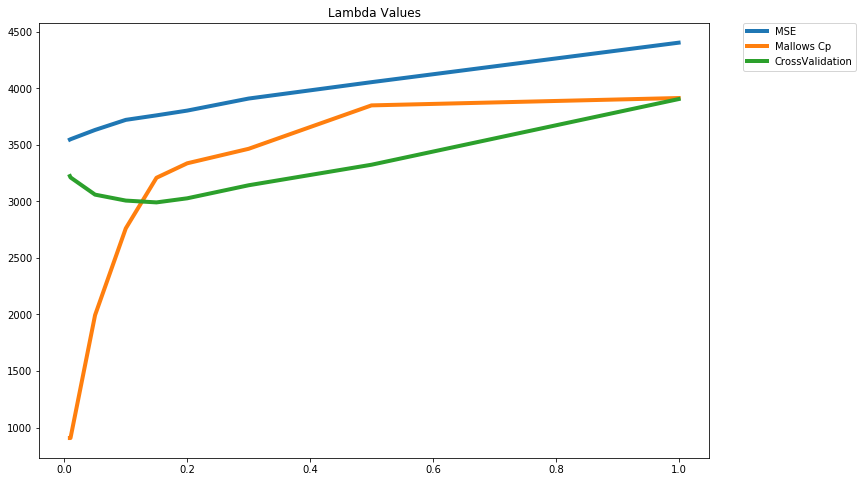

In [266]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(testLambdas,[ m * 1500 for m in mse],label="MSE", linewidth=4.0)
ax1.plot(testLambdas,[ c * 5 for c in Cp],label="Mallows Cp", linewidth=4.0)
ax1.plot(testLambdas, moose, label="CrossValidation", linewidth=4.0)
ax1.set_title("Lambda Values")
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Implement Cyclical Coordinate Descent to fit Lasso

In [128]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

In [151]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # compute prediction
    prediction = predict_output(feature_matrix, weights)
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
    ro_i = np.sum( feature_matrix[:,i] * (output - prediction + weights[i]* feature_matrix[:,i]))

#     if i == 0: # intercept -- do not regularize
    if i == -1: # There is no intercept here   
        new_weight_i = ro_i 
    elif ro_i < -l1_penalty/2.:
        new_weight_i = ro_i + l1_penalty/2.
    elif ro_i > l1_penalty/2.:
        new_weight_i = ro_i - l1_penalty/2.
    else:
        new_weight_i = 0.
    
    return new_weight_i

In [152]:
# should print 0.425558846691
import math
print (lasso_coordinate_descent_step(1, np.array([[3./math.sqrt(13),1./math.sqrt(10)],[2./math.sqrt(13),3./math.sqrt(10)]]), 
                                   np.array([1., 1.]), np.array([1., 4.]), 0.1))

0.425558846691


In [153]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    weights = np.array(initial_weights)
    converged = False
    while(not converged):
        change = 0.0
        for i in range(len(weights)):
            old_weights_i = weights[i]
            weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
            change_i = abs(old_weights_i - weights[i])
            if (change_i > change):
                change = change_i
        if (change < tolerance):
            converged = True
    return weights

In [163]:
initial_weights = np.zeros(64)
l1_penalty = 1e2
tolerance = 1.0

In [164]:
weights = lasso_cyclical_coordinate_descent(X, Y,
                                            initial_weights, l1_penalty, tolerance)

In [165]:
print(weights)

[   0.         -137.09306166  499.79237889  266.02655538    0.            0.
 -203.32548485    0.          470.98709677   27.89586504   20.43442574
   44.34286144    0.            0.            0.            0.            0.
    0.           78.60376238  117.81792625    0.           30.74620643
    0.            0.            0.            0.           13.95439093
    8.69990223    0.           11.14387578    0.            0.
    0.74533088    0.            0.            0.           93.06151625
    0.            0.            0.            0.            0.            0.
    0.            0.            3.57669858    0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.        ]


### Rescaling learned weights

Recall that we normalized our feature matrix, before learning the weights. To use these weights on a test set, we must normalize the test data in the same way.

Alternatively, we can rescale the learned weights to include the normalization, so we never have to worry about normalizing the test data:

In this case, we must scale the resulting weights so that we can make predictions with original features:

1. Store the norms of the original features to a vector called norms:
    features, norms = normalize_features(features)
2. Run Lasso on the normalized features and obtain a weights vector

3. Compute the weights for the original features by performing element-wise division, i.e.
    weights_normalized = weights / norms
    
    Now, we can apply weights_normalized to the test data, without normalizing it!
    


In [167]:
weights_normalized = weights / norms

In [168]:
print(weights_normalized)

[   0.         -137.09306166  499.79237889  266.02655538    0.            0.
 -203.32548485    0.          470.98709677   27.89586504   20.43442574
   44.34286144    0.            0.            0.            0.            0.
    0.           78.60376238  117.81792625    0.           30.74620643
    0.            0.            0.            0.           13.95439093
    8.69990223    0.           11.14387578    0.            0.
    0.74533088    0.            0.            0.           93.06151625
    0.            0.            0.            0.            0.            0.
    0.            0.            3.57669858    0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.        ]
